In [1]:
%pip install scikit-image matplotlib 

  Obtaining dependency information for scikit-image from https://files.pythonhosted.org/packages/19/23/257fc696c562639826065514d551b7b9b969520bd902c3a8e2fcff5b9e17/scikit_image-0.25.2-cp311-cp311-macosx_12_0_arm64.whl.metadata
  Obtaining dependency information for networkx>=3.0 from https://files.pythonhosted.org/packages/eb/8d/776adee7bbf76365fdd7f2552710282c79a4ead5d2a46408c9043a2b70ba/networkx-3.5-py3-none-any.whl.metadata
  Obtaining dependency information for pillow>=10.1 from https://files.pythonhosted.org/packages/84/92/6505b1af3d2849d5e714fc75ba9e69b7255c05ee42383a35a4d58f576b16/pillow-11.2.1-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for imageio!=2.35.0,>=2.33 from https://files.pythonhosted.org/packages/cb/bd/b394387b598ed84d8d0fa90611a90bee0adc2021820ad5729f7ced74a8e2/imageio-2.37.0-py3-none-any.whl.metadata
  Obtaining dependency information for tifffile>=2022.8.12 from https://files.pythonhosted.org/packages/3a/d8/1ba8f32bfc9cb69e37edeca

In [4]:
import numpy as np
from skimage import transform, io
from skimage.transform import resize
# from skimage.util import pad
image = io.imread('./demos/demo3.png', as_gray=True)

In [18]:
# image = 1 - image

In [ ]:
image = resize(image, (64,64))
theta = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = transform.radon(image, theta=theta, circle = False)
reconstructed = transform.iradon(sinogram, theta=theta, circle = False)
sinogram.shape

# Demo

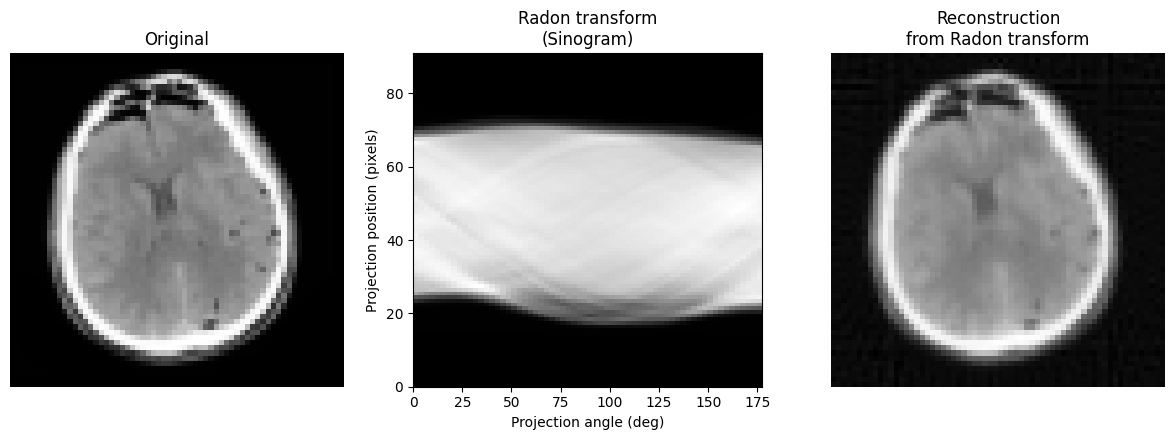

In [8]:
import matplotlib.pyplot as plt

# Modified visualization section
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4.5))

# Original image (aspect ratio preserved automatically)
ax1.set_title("Original")
original_plot = ax1.imshow(image, cmap=plt.cm.Greys_r)
ax1.axis('off')

# Calculate aspect ratios
original_aspect = image.shape[1]/image.shape[0]  # width/height
sinogram_aspect = 0.5 * (180/max(image.shape)) / (1/image.shape[0])

# Radon transform (sinogram)
ax2.set_title("Radon transform\n(Sinogram)")
sinogram_plot = ax2.imshow(
    sinogram,
    cmap=plt.cm.Greys_r,
    extent=(theta.min(), theta.max(), 0, sinogram.shape[0]),
    aspect='auto'
)

ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")

# Reconstructed image (match original aspect ratio)
ax3.set_title("Reconstruction\nfrom Radon transform")
reconstructed_plot = ax3.imshow(
    reconstructed,
    cmap=plt.cm.Greys_r,
    extent=[0, image.shape[1], image.shape[0], 0],  # Match original spatial dimensions
    aspect=1/original_aspect  # Invert aspect ratio calculation
)
ax3.axis('off')

fig.tight_layout()
plt.show()

In [9]:
sinogram.shape

(91, 64)

In [10]:
# finding the SSIM
from skimage.metrics import structural_similarity as ssim
ssim_value = ssim(image, reconstructed, data_range=image.max() - image.min())
print(f"SSIM: {ssim_value:.4f}")

SSIM: 0.9453


In [11]:
# finding the PSNR
from skimage.metrics import peak_signal_noise_ratio as psnr
psnr_value = psnr(image, reconstructed, data_range=image.max() - image.min())
print(f"PSNR: {psnr_value:.4f} dB")

PSNR: 30.0635 dB


# Creating Dataset and resizing images

In [ ]:
import os
import numpy as np
from PIL import Image, ImageOps
from skimage.transform import radon
import random

def create_sinogram(image_array, theta=None):
    if theta is None:
        theta = np.linspace(0., 180., max(image_array.shape), endpoint=False)
    if len(image_array.shape) == 3:
        image_array = np.mean(image_array, axis=2)
    image_array = (image_array - image_array.min()) / (image_array.max() - image_array.min())
    sinogram = radon(image_array, theta=theta, circle=False)
    return sinogram

def augment_image(image):
    augmentations = []
    for _ in range(80):
        img = image.copy()

        # Random rotation (-20° to 20°)
        angle = random.uniform(-20, 20)
        img = img.rotate(angle)

        # Random horizontal and/or vertical flip
        if random.choice([True, False]):
            img = ImageOps.mirror(img)
        if random.choice([True, False]):
            img = ImageOps.flip(img)

        augmentations.append(img)
    return augmentations

def process_brain_ct_images(input_dir, output_image_dir, output_sinogram_dir, target_size=(256, 256)):
    os.makedirs(output_sinogram_dir, exist_ok=True)
    os.makedirs(output_image_dir, exist_ok=True)
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    image_files = [f for f in os.listdir(input_dir) if any(f.lower().endswith(ext) for ext in image_extensions)]

    print(f"Found {len(image_files)} images to process")

    for i, filename in enumerate(image_files):
        try:
            input_path = os.path.join(input_dir, filename)
            image = Image.open(input_path).convert('RGB')

            # Resize original image and overwrite
            image = image.resize(target_size, Image.Resampling.LANCZOS)

            # Generate augmented images
            augmented_images = augment_image(image)

            for j, aug_img in enumerate(augmented_images):
                aug_img = aug_img.resize(target_size, Image.Resampling.LANCZOS)
                aug_array = np.array(aug_img)

                # Sinogram generation
                sinogram = create_sinogram(aug_array)
                sinogram_normalized = ((sinogram - sinogram.min()) / 
                                       (sinogram.max() - sinogram.min()) * 255).astype(np.uint8)
                sinogram_img = Image.fromarray(sinogram_normalized, mode='L')

                # Save sinogram
                base_name = os.path.splitext(filename)[0]
                sinogram_filename = f"{base_name}_aug{j+1}.jpg"
                sinogram_path = os.path.join(output_sinogram_dir, sinogram_filename)
                sinogram_img.save(sinogram_path, quality=95)

                # save image for the corresponding Sinogram
                base_name = os.path.splitext(filename)[0]
                image_filename = f"{base_name}_aug{j+1}.jpg"
                image_output_path = os.path.join(output_image_dir, image_filename)
                aug_img.save(f"{image_output_path}_aug{j+1}.jpg", quality=95)

            if (i + 1) % 5 == 0:
                print(f"Processed {i + 1}/{len(image_files)} images")

        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
            continue

    print("Done! Augmented sinograms saved in:", output_sinogram_dir)

# Run
if __name__ == "__main__":
    brain_ct_dir = "./Datasets/brain_CT"
    sinogram_output_dir = "./Datasets/brain_CT_sinograms_64_augmented"
    output_image_dir = "./Datasets/brain_CT_64_augmented"
    print("Starting augmentation (80x) and sinogram generation...")
    print("Only using rotation and flipping")
    print()

    process_brain_ct_images(brain_ct_dir, output_image_dir, sinogram_output_dir)

Starting augmentation (80x) and sinogram generation...
Only using rotation and flipping

Found 125 images to process
Processed 5/125 images
Processed 10/125 images
Processed 15/125 images
Processed 20/125 images
Processed 25/125 images
Processed 30/125 images
Processed 35/125 images
Processed 40/125 images
Processed 45/125 images
Processed 50/125 images
Processed 55/125 images
Processed 60/125 images
Processed 65/125 images
Processed 70/125 images
Processed 75/125 images
Processed 80/125 images
Processed 85/125 images
Processed 90/125 images
Processed 95/125 images
Processed 100/125 images
Processed 105/125 images
Processed 110/125 images
Processed 115/125 images
Processed 120/125 images
Processed 125/125 images
Done! Augmented sinograms saved in: ./Datasets/brain_CT_sinograms_64_augmented
